Import des librairies nécessaires

In [36]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,classification_report
from imblearn.over_sampling import SMOTE

Liste des path des différents datasets

In [37]:
normalTestPath = '../pneumonie/test/NORMAL'
pneumoniaTestPath = '../pneumonie/test/PNEUMONIA'

normalTrainPath = '../pneumonie/train/NORMAL'
pneumoniaTrainPath = '../pneumonie/train/PNEUMONIA'

normalValPath = '../pneumonie/val/NORMAL'
pneumoniaValPath = '../pneumonie/val/PNEUMONIA'

Function qui crée le dataset et le labelise, arrange les données pour qu'elle est toute la même shape, mélange aussi le dataset

In [38]:
def createTrainDataSet(normalPath, pneumoniaPath, bool=False):
    data = []
    labels = []

    for file in os.listdir(normalPath):
        if file.endswith('.DS_Store'):
            continue
        img = Image.open(os.path.join(normalPath, file)).convert('L')
        img = img.resize((224, 224))  
        img = np.array(img, dtype=np.float32)
        img = img.flatten()
        data.append(img)
        labels.append('normal') 

    for file in os.listdir(pneumoniaPath):
        if file.endswith('.DS_Store'):
            continue
        img = Image.open(os.path.join(pneumoniaPath, file)).convert('L')
        img = img.resize((224, 224))
        img = np.array(img, dtype=np.float32)
        img = img.flatten()
        if bool== True:
            if 'bacteria' in file:
                labels.append('bacteria')
            else:
                labels.append('virus') 
            data.append(img)
        else:
            if 'bacteria' in file:
                labels.append('bacteria')
                data.append(img)


    return np.array(data), np.array(labels)

dataTrain, labelTrain = createTrainDataSet(normalTrainPath, pneumoniaTrainPath, True)
dataTest, labelTest = createTrainDataSet(normalTestPath, pneumoniaTestPath, True)
dataVal, labelVal = createTrainDataSet(normalValPath, pneumoniaValPath, True)

print("Data train shape:", dataTrain.shape)
print("Label train shape:", labelTrain.shape)
print("Data test shape:", dataTest.shape)
print("Label test shape:", labelTest.shape)
print("Data val shape:", dataVal.shape)
print("Label val shape:", labelVal.shape)

Data train shape: (5216, 50176)
Label train shape: (5216,)
Data test shape: (624, 50176)
Label test shape: (624,)
Data val shape: (16, 50176)
Label val shape: (16,)


Function qui représente la répartition des maladies sur les différents datasets

In [39]:
def getRepartition(label, dataset):
    fig, ax = plt.subplots()

    virusRepartition = 0
    bacteriaRepartition = 0
    normalRepartition = 0

    for i in range(len(label)):
        if label[i] == 'virus':
            virusRepartition += 1
        elif label[i] == 'bacteria':
            bacteriaRepartition += 1
        else:
            normalRepartition += 1

    x = ['virus', 'bacteria', 'normal']
    counts = [virusRepartition, bacteriaRepartition, normalRepartition]
    bar_labels = ['red', 'blue', 'orange']
    bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

    ax.bar(x, counts, label=bar_labels, color=bar_colors)

    print(f"virus: {virusRepartition}, bacteria: {bacteriaRepartition}, normal: {normalRepartition}")

    ax.set_ylabel('Repartition of virus and bacteria')
    ax.set_title('Repartition of virus and bacteria in dataset ' + dataset)
    ax.legend(title='Virus and Bacteria', loc='upper right')

    plt.show()

Montre la répartition de entre virus,normal et pneumonie sur les différents dataset

virus: 1345, bacteria: 2530, normal: 1341


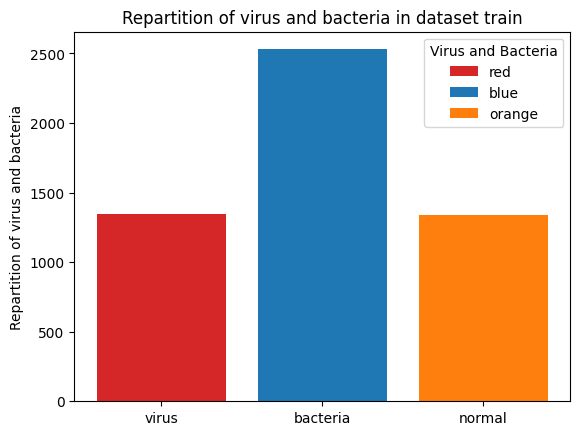

virus: 148, bacteria: 242, normal: 234


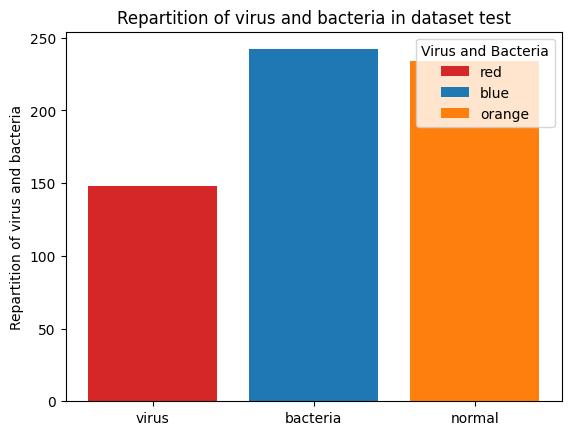

virus: 0, bacteria: 8, normal: 8


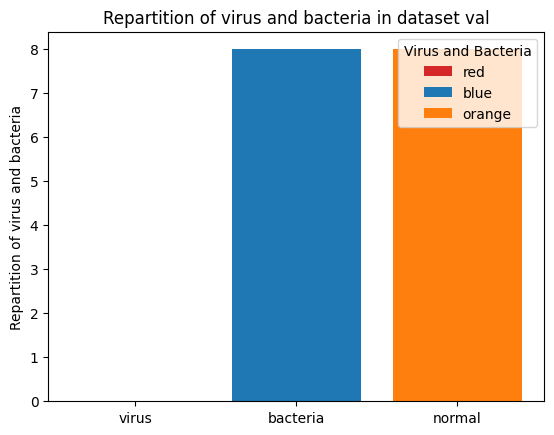

In [40]:
getRepartition(labelTrain, 'train')
getRepartition(labelTest, 'test')
getRepartition(labelVal , 'val')

Entraine le model Stochastic Gradient Descent sur le dataset d'entrainement

In [41]:
sgd_clf = SGDClassifier(random_state=42) 

sgd_clf.fit(dataTrain, labelTrain)

SGDClassifier(random_state=42)

Test du model Stochastic Gradient Descent sur la dataset de test

In [42]:
predictedTest = sgd_clf.predict(dataTest)

accuracy = accuracy_score(labelTest, predictedTest)


print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.5576923076923077
              precision    recall  f1-score   support

    bacteria       0.50      0.99      0.67       242
      normal       0.95      0.37      0.53       234
       virus       0.41      0.15      0.22       148

    accuracy                           0.56       624
   macro avg       0.62      0.50      0.47       624
weighted avg       0.65      0.56      0.51       624



Utilisation de smote pour resampler le nombre d'élément de chaque classe

In [43]:
smote = SMOTE(sampling_strategy='not majority', random_state=42)

X_resampled, y_resampled = smote.fit_resample(dataTrain, labelTrain)

Réentraine le model avec le resample

In [44]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_resampled, y_resampled)

predictedTest = sgd_clf.predict(dataTest)

accuracy = accuracy_score(labelTest, predictedTest)


print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.6105769230769231
              precision    recall  f1-score   support

    bacteria       0.61      0.95      0.75       242
      normal       0.96      0.33      0.49       234
       virus       0.44      0.49      0.46       148

    accuracy                           0.61       624
   macro avg       0.67      0.59      0.57       624
weighted avg       0.70      0.61      0.58       624



Le resample permet que une classe ne soit pas toujours très juste et les autres très peu car il y a moins de désequilibre entre les classes

Test avec avec d'autre hyper paramètre pour le modèle

In [45]:
sgd_clf = SGDClassifier(
    loss="log_loss",           
    class_weight="balanced",   
    learning_rate="adaptive",
    eta0=0.01,                 
    random_state=42
)

sgd_clf.fit(dataTrain, labelTrain)

predictedTest = sgd_clf.predict(dataTest)

accuracy = accuracy_score(labelTest, predictedTest)


print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.6025641025641025
              precision    recall  f1-score   support

    bacteria       0.61      0.87      0.72       242
      normal       0.94      0.35      0.52       234
       virus       0.43      0.56      0.49       148

    accuracy                           0.60       624
   macro avg       0.66      0.59      0.57       624
weighted avg       0.69      0.60      0.59       624



In [46]:
sgd_clf = SGDClassifier(
    random_state=42,
    loss='log_loss',
    alpha=0.01,  
    penalty='l2',  
    learning_rate='constant',  
    eta0=0.05,  
    max_iter=1000,
    tol=1e-3 
)

sgd_clf.fit(dataTrain, labelTrain)

predictedTest = sgd_clf.predict(dataTest)

accuracy = accuracy_score(labelTest, predictedTest)


print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.6891025641025641
              precision    recall  f1-score   support

    bacteria       0.92      0.68      0.78       242
      normal       0.82      0.63      0.71       234
       virus       0.45      0.80      0.57       148

    accuracy                           0.69       624
   macro avg       0.73      0.70      0.69       624
weighted avg       0.77      0.69      0.71       624



## 2 classes

In [47]:
dataTrain, labelTrain = createTrainDataSet(normalTrainPath, pneumoniaTrainPath, False)
dataTest, labelTest = createTrainDataSet(normalTestPath, pneumoniaTestPath, False)

sgd_clf = SGDClassifier(random_state=42) 

sgd_clf.fit(dataTrain, labelTrain)

predictedTest = sgd_clf.predict(dataTest)

accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.7605042016806722
              precision    recall  f1-score   support

    bacteria       0.68      0.98      0.81       242
      normal       0.97      0.53      0.69       234

    accuracy                           0.76       476
   macro avg       0.83      0.76      0.75       476
weighted avg       0.82      0.76      0.75       476



Test avec d'autres hyperparamètres

In [48]:
sgd_clf = SGDClassifier(random_state=42,loss='log_loss', max_iter=5000, tol=1e-4,
                        class_weight='balanced', learning_rate='optimal', eta0=0.01) 

sgd_clf.fit(dataTrain, labelTrain)

predictedTest = sgd_clf.predict(dataTest)

accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.7142857142857143
              precision    recall  f1-score   support

    bacteria       0.64      0.99      0.78       242
      normal       0.98      0.43      0.60       234

    accuracy                           0.71       476
   macro avg       0.81      0.71      0.69       476
weighted avg       0.81      0.71      0.69       476



In [49]:
sgd_clf = SGDClassifier(random_state=42, loss='log_loss', alpha=0.01,
                    max_iter=1000) 

sgd_clf.fit(dataTrain, labelTrain)

predictedTest = sgd_clf.predict(dataTest)

accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.819327731092437
              precision    recall  f1-score   support

    bacteria       0.75      0.96      0.84       242
      normal       0.94      0.68      0.79       234

    accuracy                           0.82       476
   macro avg       0.85      0.82      0.81       476
weighted avg       0.85      0.82      0.82       476



In [50]:
sgd_clf = SGDClassifier(
    random_state=42,
    loss='log_loss',
    alpha=0.01,  
    penalty='l2',  
    learning_rate='constant',  
    eta0=0.01,  
    max_iter=1000,
    tol=1e-3 
)

sgd_clf.fit(dataTrain, labelTrain)
predictedTest = sgd_clf.predict(dataTest)
accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.8256302521008403
              precision    recall  f1-score   support

    bacteria       0.76      0.96      0.85       242
      normal       0.95      0.68      0.79       234

    accuracy                           0.83       476
   macro avg       0.85      0.82      0.82       476
weighted avg       0.85      0.83      0.82       476



In [51]:
sgd_clf = SGDClassifier(
    random_state=42,
    loss='log_loss',
    alpha=0.005,  
    penalty='l2',  
    learning_rate='constant',  
    eta0=0.01,  
    max_iter=1000,
    tol=1e-3 
)

sgd_clf.fit(dataTrain, labelTrain)
predictedTest = sgd_clf.predict(dataTest)
accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.5714285714285714
              precision    recall  f1-score   support

    bacteria       0.54      1.00      0.70       242
      normal       1.00      0.13      0.23       234

    accuracy                           0.57       476
   macro avg       0.77      0.56      0.47       476
weighted avg       0.77      0.57      0.47       476



In [52]:
sgd_clf = SGDClassifier(
    random_state=42,
    loss='log_loss',
    alpha=0.01,  
    penalty='elasticnet',  
    learning_rate='constant',  
    eta0=0.01,  
    max_iter=1000,
    tol=1e-3 
)

sgd_clf.fit(dataTrain, labelTrain)
predictedTest = sgd_clf.predict(dataTest)
accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.8067226890756303
              precision    recall  f1-score   support

    bacteria       0.74      0.96      0.84       242
      normal       0.94      0.65      0.77       234

    accuracy                           0.81       476
   macro avg       0.84      0.80      0.80       476
weighted avg       0.84      0.81      0.80       476



In [53]:
sgd_clf = SGDClassifier(
    random_state=42,
    loss='log_loss',
    alpha=0.01,  
    penalty='l2',  
    learning_rate='constant',  
    eta0=0.05,  
    max_iter=1000,
    tol=1e-3 
)

sgd_clf.fit(dataTrain, labelTrain)
predictedTest = sgd_clf.predict(dataTest)
accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.8907563025210085
              precision    recall  f1-score   support

    bacteria       0.85      0.95      0.90       242
      normal       0.94      0.83      0.88       234

    accuracy                           0.89       476
   macro avg       0.90      0.89      0.89       476
weighted avg       0.90      0.89      0.89       476



In [54]:
sgd_clf = SGDClassifier(
    random_state=42,
    loss='log_loss',
    alpha=0.01,  
    penalty='l2',  
    learning_rate='invscaling',  
    eta0=0.05,  
    power_t=0.5,
    max_iter=1000,
    tol=1e-3 
)

sgd_clf.fit(dataTrain, labelTrain)
predictedTest = sgd_clf.predict(dataTest)
accuracy = accuracy_score(labelTest, predictedTest)
print("Test Accuracy: ", accuracy)
print(classification_report(labelTest, predictedTest))

Test Accuracy:  0.6638655462184874
              precision    recall  f1-score   support

    bacteria       0.60      1.00      0.75       242
      normal       0.99      0.32      0.48       234

    accuracy                           0.66       476
   macro avg       0.79      0.66      0.62       476
weighted avg       0.79      0.66      0.62       476

